# Non-Responsive Coding

## Evironment Set-up

Use options below to uncomment drive path of choice:

In [69]:
# macOS/OS X
# drive_path = '/Volumes/Brain2017/data/dynamic-brain-workshop/brain_observatory_cache/'

# Windows (a good guess)
# drive_path = 'e:/data/dynamic-brain-workshop/brain_observatory_cache'

# Linux (will vary; the following is possibly what Ubuntu will do)
# drive_path = '/media/Brain2017/data/dynamic-brain-workshop/brain_observatory_cache'

# AWS
drive_path = '/data/dynamic-brain-workshop/brain_observatory_cache/'

Import modules and Brain Observatory cache:

In [70]:
# We need to import these modules to get started
import numpy as np
import pandas as pd
import os
import sys
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = os.path.join(drive_path,'brain_observatory_manifest.json')
print manifest_file

boc = BrainObservatoryCache(manifest_file=manifest_file)

/data/dynamic-brain-workshop/brain_observatory_cache/brain_observatory_manifest.json


In [4]:
# Download a list of all targeted areas
targeted_structures = boc.get_all_targeted_structures()
print 'all targeted structures: ' + str(targeted_structures)

# Download a list of all stimuli
stims = boc.get_all_stimuli()
print 'all stimuli: ' + str(stims)

all targeted structures: [u'VISal', u'VISam', u'VISl', u'VISp', u'VISpm', u'VISrl']
all stimuli: ['drifting_gratings', 'locally_sparse_noise', 'locally_sparse_noise_4deg', 'locally_sparse_noise_8deg', 'natural_movie_one', 'natural_movie_three', 'natural_movie_two', 'natural_scenes', 'spontaneous', 'static_gratings']


In [5]:
# Print Dictionary of Cre-lines availble in BOC paired with their layer of expression
cre_to_layer={} 
cre_to_layer['Cux2-CreERT2']='Layer 2/3 & 4'
cre_to_layer['Emx1-IRES-Cre']='Pan excitatory expression'
cre_to_layer['Nr5a1-Cre']='Layer 4'
cre_to_layer['Rbp4-Cre_KL100']='Layer 5'
cre_to_layer['Rorb-IRES2-Cre']='Layer 4'
cre_to_layer['Scnn1a-Tg3-Cre']='Layer 4'
print(cre_to_layer)

{'Nr5a1-Cre': 'Layer 4', 'Cux2-CreERT2': 'Layer 2/3 & 4', 'Scnn1a-Tg3-Cre': 'Layer 4', 'Rbp4-Cre_KL100': 'Layer 5', 'Rorb-IRES2-Cre': 'Layer 4', 'Emx1-IRES-Cre': 'Pan excitatory expression'}


## Import Data from Visual Area

In [6]:
# Choose a visual area and Cre-line to begin
visual_area = 'VISrl'

# To get list of desired experimental containers from VISUAL AREA
# Import data from targeted area WITHOUT SPECIFYING CRE-LINE
exps = boc.get_experiment_containers(targeted_structures=[visual_area])

# To get list of desired experimental containers from VISUAL AREA AND SPECIFIC CRE-LINE
# Make a list of desired cre lines (can use cre_to_layer{} to find cre lines)
# cre=[]
# exps = boc.get_experiment_containers(targeted_structures=[visual_area], cre_lines=[cre])

#Create Data Frame
exps_df=pd.DataFrame(exps)

In [7]:
# Make list of experimental id containers for visrl
exp_lis=[]
for exp in exps_df['id']:
    exp_lis.append(exp)
print exp_lis 

[571541563, 576208803, 580051757, 575892535, 560363325, 560782654, 576714442, 574034739, 573864648, 571039045, 569981238, 569645688, 570008442, 553568029, 570428250, 575710989]


In [8]:
# OPTION TO VISUALIZE what each experimental container contains, NOT NECESSARY TO CONTINUE NOTEBOOK

# Get information from experimental session for one id from one id container
# There are three sessions in every container that correspond to the 3 1 hr imaging sessions

def get_expcontainer_dataframe(exp_container):
    """Creates  a panda dataframe for a single experimental container
    INPUT: exp_container= the experimental container id for one mouse
    OUTPUT: expt_container_info_df: dataframe for all experimental data corresponding to a single experimental container id"""
    
    # Information 
    expt_session_info = boc.get_ophys_experiments(experiment_container_ids=[exp_container])
    
    # This returns a list of dictionaries with information regarding experimental sessions of our specified exp container
    print(expt_session_info)

    # Create Data Frame of experimental sessions in your container
    expt_session_info_df = pd.DataFrame(expt_session_info) #create pd dataframe so can look at each diff session from each expt
    return expt_session_info_df

In [9]:
#Pull session ids 
#Input: list of exp containers
#Output: Dictionary with value exp container and key dictionary of session ids

session_ids={}
def pull_session_id(exp_lis):
    """INPUT: a list of experimental containers id's of mice of interest
    OUTPUT: a dictionary where each value is an experimental container id
        its corresponding key is a dictionary pairing session type [A,B,C/C2] with session ID
    NOTE: C and C2 are mutually exclusive options. Mice run before 09/2016 at the Allen are run on procedure C
        After this date, an additional sparse noise stimuli is added to the session and it is renamed session C2 for all future mice"""
    
    for exp in exp_lis:
        new_index_session={}
        
        expt_session_info = boc.get_ophys_experiments(experiment_container_ids=[exp])
        expt_session_info_df = pd.DataFrame(expt_session_info)
        
        session_id_A=expt_session_info_df[expt_session_info_df.session_type=='three_session_A'].id.values[0]
        new_index_session['session_id_A']=session_id_A
        
        session_id_B=expt_session_info_df[expt_session_info_df.session_type=='three_session_B'].id.values[0]
        new_index_session['session_id_B']=session_id_B
        
         # Make sure to pull session C2 if session C not available
        session_types = ['three_session_C', 'three_session_C2']
        session_id_C = expt_session_info_df[expt_session_info_df['session_type'].isin(session_types)].id.values[0]
        new_index_session['session_id_C']=session_id_C
        
        session_ids[exp]=new_index_session
    return session_ids

# Now run function to gather session ids for desired experimental containers
pull_session_id(exp_lis)

{553568029: {'session_id_A': 553568031,
  'session_id_B': 554021353,
  'session_id_C': 554284637},
 560363325: {'session_id_A': 560730718,
  'session_id_B': 560563735,
  'session_id_C': 560363327},
 560782654: {'session_id_A': 560866155,
  'session_id_B': 562222842,
  'session_id_C': 560782656},
 569645688: {'session_id_A': 569645690,
  'session_id_B': 569722788,
  'session_id_C': 569818138},
 569981238: {'session_id_A': 570236381,
  'session_id_B': 570059563,
  'session_id_C': 569981240},
 570008442: {'session_id_A': 570008444,
  'session_id_B': 570080979,
  'session_id_C': 570236726},
 570428250: {'session_id_A': 571006300,
  'session_id_B': 570909395,
  'session_id_C': 570428252},
 571039045: {'session_id_A': 571642389,
  'session_id_B': 571418966,
  'session_id_C': 571255084},
 571541563: {'session_id_A': 571541565,
  'session_id_B': 572489757,
  'session_id_C': 572505201},
 573864648: {'session_id_A': 574823092,
  'session_id_B': 573864650,
  'session_id_C': 574180032},
 574034739

In [13]:
#Get datasets for a desired session type ['session_id_A', 'session_id_B', or 'session_id_C'] for a list of experimental containers

def get_dataset(exps, sessiontype):
    """Retrieve datasets of a specific session type for a list of experimental containers
    INPUT: 
        exps:list of experimental containers
        sessiontype: choose from one of the following: ['session_id_A', 'session_id_B', or 'session_id_C']
    OUTPUT: Dictionary where each value is an experimental container id
                each key if corresponding dataset
    NOTE: This for loop is inefficient and will take a minute to run"""
    datasets={}
    for exp in exps:
        dataset = boc.get_ophys_experiment_data(ophys_experiment_id=(session_ids[exp][sessiontype]))
        datasets[exp]=dataset
    return datasets
data_b=get_dataset(exp_lis, 'session_id_B')

In [33]:
# Now create a dictionary with the frame numbers for the start and stop of each epoch (stimulus) for a given exp container and session type
def get_epoch_table(exps, datasets):
    """Creates dictionary where value is experimental container number
             key is the epoch table associated with exp container for a given session type
     INPUT:
        exps: list of experimental containers
        datasets: dataset varialbe attained from function get_dataset()
     OUTPUT: 
         epochtable: list of epochs (stimulus type for session type A, B, or C) with start and stop frame numbers for each epoch
            note: each exp container has its own unique epochtable
    NOTE: This for loop will take at least 5 minutes to run"""
    epochtable={}
    for exp in exps:
        epochtable[exp]=datasets[exp].get_stimulus_epoch_table()
    return epochtable
epoch_table_B=get_epoch_table(exp_lis, data_b)

In [41]:
# Function to create epoched delta f array traces for each cell over the 3 sessions in dictionary called "ca_trace_by_epoch"
# Like stimuli will be concatenated
def create_delta_traces(datasets, exps, epochtable):
    """Retrieve calcium traces by epoch (stimulus type) from a dictionary of datasets of a given type (session A, B, or C)
            for a list of experimental containers.
            exps must be same list used in get_dataset() function
            dataset must be generated by get_dataset() function
    INPUT:
        exps: list of experimental containers
        datasets: dataset varialbe attained from function get_dataset()
        epochtable: use dictionary from get_epoch_tables() function where values=exp cont's and keys=epoch tables
    OUTPUT: 
       
        ca_by_epoch: this is a dictionary where each value is an experimental container
            each key is a nested dictionary where value/key pairs are epoch type and its corresponsing ca2+ trace
                note: if a stimulus type is present more than once in a session, its traces are concatenated into one trace
    NOTE: This for loop is inefficient and will take a minute to run
            """
    delta_traces={}
    ca_by_exp={}
    for exp in exp_lis:
        X=datasets[exp].get_dff_traces()
        if exp==exp_lis[0]:
            epochtable_list=epochtable[exps[0]]['stimulus'].unique()
        timestamps=X[0]
        trace=X[1]
        delta_traces[exp]=[timestamps, trace]
        ca_trace_by_epoch={}
        for stim_n in epochtable_list:
            curr_ca = []
            for ind, stim_row in epochtable[exps[0]].iterrows():
                if stim_row['stimulus'] == stim_n:
                    Ca=delta_traces[exp][1]
                    curr_ca.append(Ca[:, stim_row['start'] : stim_row['end']])
            curr_ca = np.concatenate(curr_ca, axis=1)
            ca_trace_by_epoch[stim_n] = curr_ca
        ca_by_exp[exp]=ca_trace_by_epoch
    return ca_by_exp
ca_by_exp= create_delta_traces(data_b, exp_lis, epoch_table_B)

In [44]:
# Create a list of epoch types within session of interest for future funtcions
def get_epoch_list(exps, epochtable):
    """Creates list of stimulus types for given session
     INPUT:
        exps: list of experimental containers
        epochtalbe: Use epochtable attained from function get_epoch_table
     OUTPUT: 
         epochtable_list: a list of epoch type (stimulus type) for a given session type (A, B, or C)
            note: this is universal for all experimental containers and only indicates stimulus type present in session"""
    epochtable_list=epochtable[exps[0]]['stimulus'].unique()
    return epochtable_list
epoch_B_list=get_epoch_list(exp_lis, epoch_table_B)

In [46]:
# # Stimulus Dictionary
# stim_dict={}
# for exp in exp_lis:
#     temp_exp_df=data_b[exp]
#     stim_dict[exp]=temp_exp_df.get_stimulus_table(stimulus_name='natural_scenes')

In [49]:
# Create a dictionary with the stimulus table contained frame numbers for natural scenes images for each experimental container
def get_stim_dict(exps, datasets):
    """ Creates dictionary to determine timing of different images in natural scenes epoch
    INPUT:
        exps: list of experimental containers
        datasets: dataset varialbe attained from function get_dataset()
    OUTPUT:
        stim_dict: a dictionary where each value is an experimental container id
            each key is the frame numbers for individual images presented during natural scenes"""
    stim_dict={}
    for exp in exps:
        temp_exp_df=datasets[exp]
        stim_dict[exp]=temp_exp_df.get_stimulus_table(stimulus_name='natural_scenes')
    return stim_dict
stim_dict=get_stim_dict(exp_lis, data_b)

# Sort Cells by "Responsive" and "Non-responsive"

In [51]:
# Get info for all cell specimens
cell_specimens = pd.DataFrame(boc.get_cell_specimens())

In [53]:
# Print list of information available for each cell specimen
specimen_info=cell_specimens.keys()

In [106]:
# Use function to create a dictionary profiling responsivity by category for cells in each exp container
# Categories include:
    # ns_nor= non-reponsive to natural scenes epoch
    # sg_not= non-responsive to static gratings epoch
    # dg_not= non-responsive to drifting gratings epoch
    # nor_= non-responsive to all epoch types
    # all_= a list of all cells for the experimental container within the current imaging session type
def get_responsivity_status(exps, cell_specimens, sessiontype):
    """ Creates a dictionary cell_categories
        Value=exp container id
        keys= dictionaries for different categories of responsivity
    Input:
        exps: list of experimental containers
        cell_specimens=DataFrame for all cell related information for Brain Observatory cache
        sessiontype: choose from one of the following: ['session_id_A', 'session_id_B', or 'session_id_C']
    Output:
        cell_categories:dictionary of dictionaries indicating responsivity profiles
    """
    ns_nor_={}
    sg_nor_={}
    dg_nor_={}
    nor_={}
    all_={}

    for exp in exps:
        #Isolate cells for experimental container id
        expt_container_id=exp
        specimens=cell_specimens[(cell_specimens['experiment_container_id']==expt_container_id)]
        all_[exp]=specimens['cell_specimen_id']
    
        #Totally non-responsive cells
        isnor = ((specimens.p_dg>0.05) | (specimens.peak_dff_dg<3)) & ((specimens.p_sg>0.05) | (specimens.peak_dff_sg<3)) & ((specimens.p_ns>0.05) | (specimens.peak_dff_ns<3)) & (specimens.rf_chi2_lsn>0.05)
        nor=specimens[isnor] 
        nor_[exp]=nor['cell_specimen_id']
    
        #Non-responsive to ns
        if sessiontype=='session_id_B':
            isepochnor=((specimens.p_ns>0.05) | (specimens.peak_dff_ns<3))
            ns_nor=specimens[~isnor & isepochnor]
            ns_nor_[exp]=ns_nor['cell_specimen_id']
    
        #Non-responsive to dg
        if sessiontype=='session_id_A':
            isepochnor=((specimens.p_dg>0.05) | (specimens.peak_dff_dg<3))
            dg_nor=specimens[~isnor & isepochnor]
            dg_nor_[exp]=dg_nor['cell_specimen_id']
    
        #Non-responsive to sg
        if sessiontype=='session_id_B':
            isepochnor=((specimens.p_sg>0.05) | (specimens.peak_dff_sg<3))
            sg_nor=specimens[~isnor & isepochnor]
            sg_nor_[exp]=sg_nor['cell_specimen_id']
    if sessiontype=='session_id_A':
        cell_categories={'nor_':nor_, 'all_':all_, 'dg_nor_':dg_nor_}
    if sessiontype=='session_id_B':
        cell_categories={'nor_':nor_, 'ns_nor_':ns_nor_, 'sg_nor_':sg_nor_, 'all_':all_}
    if sessiontype=='session_id_C':
        cell_categories={'nor_':nor_, 'all_':all_}
    return cell_categories
cell_categories=get_responsivity_status(exp_lis, cell_specimens, 'session_id_B')

In [60]:
# Gather cell indices fopr each exp container by looking across 3 datasets within each container
# Each key experimental id
# Each value list of paired cell speciemn id and cell index
#data_b
#delta_traces
def get_cell_indices(exps, datasets):
    """Creates a dictionary with values as exp container ids
        keys are a dictionary containing cell ids paired with cell indices
        INPUT:
            exps: list of experimental containers
            datasets: dataset varialbe attained from function get_dataset()
        OUTPUT:
            Dictionary, cell_indices_by_expcontainer, pairing cell indices with cell ids"""
    cell_indices_by_expcontainer={}
    
    for exp in exps:
    
        # Create dictionary for id to index map for each exp container
        specimen_index_map = {}
    
        # Get cell specimen ids for session B
        specimens_lis=data_b[exp].get_cell_specimen_ids()
    
        #Get cell indices for session B
        specimen_id_temp=data_b[exp].get_cell_specimen_indices(specimens_lis)
    
        # Create map
        specimen_index_map.update({spid: spind for spid, spind in zip(specimens_lis, specimen_id_temp)})
    
        # Update exp container with id to index map
        cell_indices_by_expcontainer[exp]=specimen_index_map
        
    return cell_indices_by_expcontainer
cell_indices=get_cell_indices(exp_lis, data_b)

In [161]:
# Create a dictionary where each value is an experimental container id
# each key is a set of dictionaries containing a list of cell indices for each responsivity category
def get_index_from_id(cell_indices, sessiontype):
    """
     Create a dictionary where each value is an experimental container id
        each key is a set of dictionaries containing a list of cell indices for each responsivity category
    INPUT:
        cell_indices: output from get_cell_indices function
        sessiontype: choose from one of the following: ['session_id_A', 'session_id_B', or 'session_id_C']
    OUTPUT:
        indexlist_by_reponsivity: dictionary by exp container id containing list of cell indices for each responsivity category
        
    """
    indexlist_by_reponsivity={}
    if sessiontype=='session_id_A':
        for exp in cell_indices:
            cell_indexs = cell_indices[exp]
            new_index = {}
            a_nor=[]
            a_nor_=[]
            for cell in cell_categories['nor_'][exp]:
                a_nor.append(cell)
            a_all=[]
            a_all_=[]
            for cell in cell_categories['all_'][exp]:
                a_all.append(cell)
            a_dg_nor=[]
            a_dg_nor_=[]
            for cell in cell_categories['dg_nor_'][exp]:
                if cell not in a_nor_:
                    a_dg_nor.append(cell)
            for cell in cell_indexs:
                if cell in a_nor:
                    a_nor_.append(cell_indexs[cell])
                if cell in a_all:
                    a_all_.append(cell_indexs[cell])
                if cell in a_dg_nor:
                    a_dg_nor_.append(cell_indexs[cell])
            indexlist_by_reponsivity[exp]={'nor':a_nor_, 'all':a_all_, 'dg_nor':a_dg_nor}
    if sessiontype=='session_id_B':
        for exp in cell_indices:
            cell_indexs = cell_indices[exp]
            new_index = {}
            b_nor=[]
            b_nor_=[]
            for cell in cell_categories['nor_'][exp]:
                b_nor.append(cell)
            b_all=[]
            b_all_=[]
            for cell in cell_categories['all_'][exp]:
                b_all.append(cell)
            b_ns_nor=[]
            b_ns_nor_=[]
            for cell in cell_categories['ns_nor_'][exp]:
                if cell not in b_nor_:
                    b_ns_nor.append(cell)
            b_sg_nor=[]
            b_sg_nor_=[]
            for cell in cell_categories['sg_nor_'][exp]:
                if cell not in b_nor_:
                    b_sg_nor.append(cell)
            for cell in cell_indexs:
                if cell in b_nor:
                    b_nor_.append(cell_indexs[cell])
                if cell in b_all:
                    b_all_.append(cell_indexs[cell])
                if cell in b_ns_nor:
                    b_ns_nor_.append(cell_indexs[cell])
                if cell in b_sg_nor:
                    b_sg_nor_.append(cell_indexs[cell])
            indexlist_by_reponsivity[exp]={'nor':b_nor_, 'all':b_all_, 'ns_nor':b_ns_nor_, 'sg_nor':b_sg_nor_}
    if sessiontype=='session_id_C':
        for exp in cell_indices:
            cell_indexs = cell_indices[exp]
            new_index = {}
            c_nor=[]
            c_nor_=[]
            for cell in cell_categories['nor_'][exp]:
                c_nor.append(cell)
            c_all=[]
            c_all_=[]
            for cell in cell_categories['all_'][exp]:
                c_all.append(cell)
            for cell in cell_indexs:
                if cell in c_nor:
                    c_nor_.append(cell_indexs[cell])
                if cell in c_all:
                    c_all_.append(cell_indexs[cell])
            indexlist_by_reponsivity[exp]={'nor':c_nor_, 'all':c_all_}
    return indexlist_by_reponsivity
id_to_index=get_index_from_id(cell_indices, 'session_id_B')

In [163]:
def filter_trace_by_cell_index(exp_container_id, delta_trace, list_of_cell_indices):
    """Here exp_container_id=mouse container id
    delta_trace=2D array,array of arrays where each array is a cell's delta f trace for the epoch/stimuli
    list_of_cell_indices= list of cell indices that need to be sliced out and put into new array of arrays"""
    filtered_trace=[]
    for index in list_of_cell_indices:
        filtered_trace.append(delta_trace[index])
    return filtered_trace

In [209]:
def get_traces_filtered_by_responsivity(exps, epochlist, ca_by_exp, indexlist_by_responsivity):
    for exp in exps:
        filtered_trace[exp]={}
        for epoch in epochlist:
            filtered_trace[exp][str(epoch)]={}
            for i in indexlist_by_responsivity[exp]:
                filtered_trace[exp][str(epoch)][str(i)]=(filter_trace_by_cell_index(exp, ca_by_exp[exp][epoch], id_to_index[exp][i]))
    return filtered_trace
filteredtrace=get_traces_filtered_by_responsivity(exp_lis, epoch_B_list, ca_by_exp, id_to_index)

## NON Responsive Activity Profiles

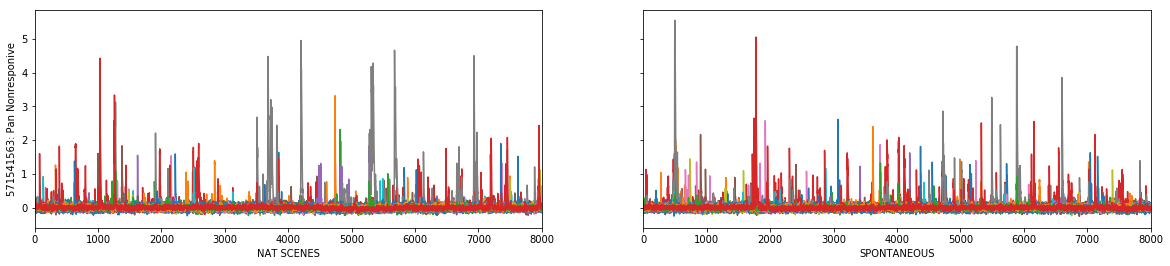

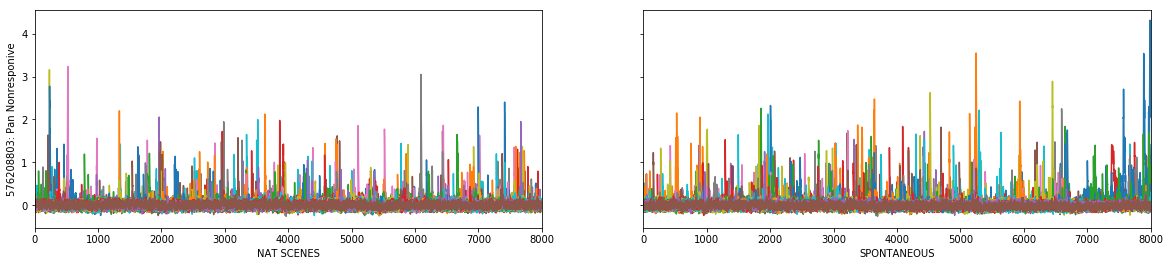

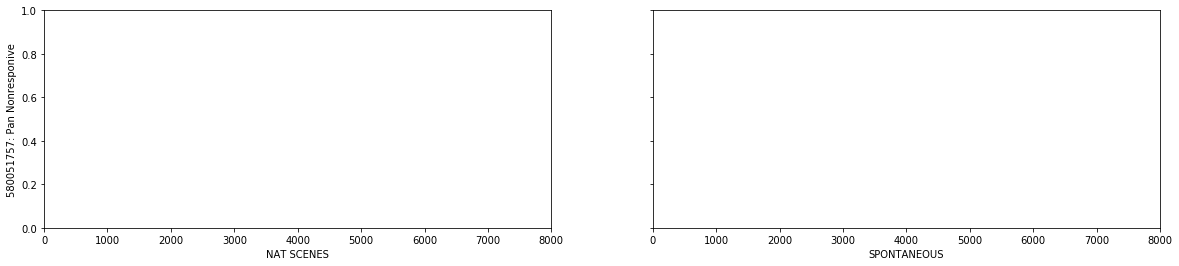

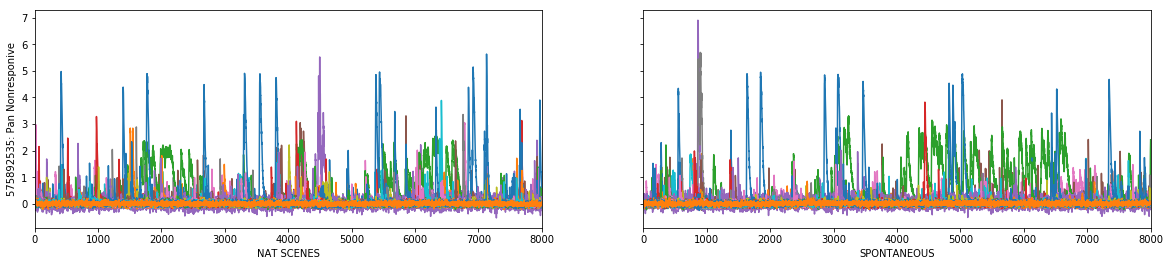

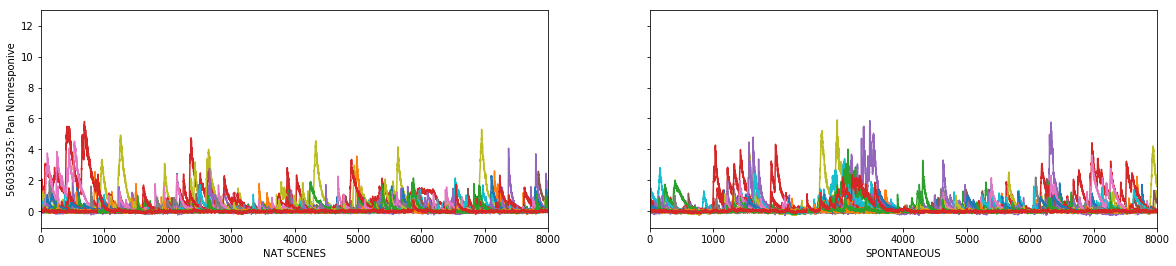

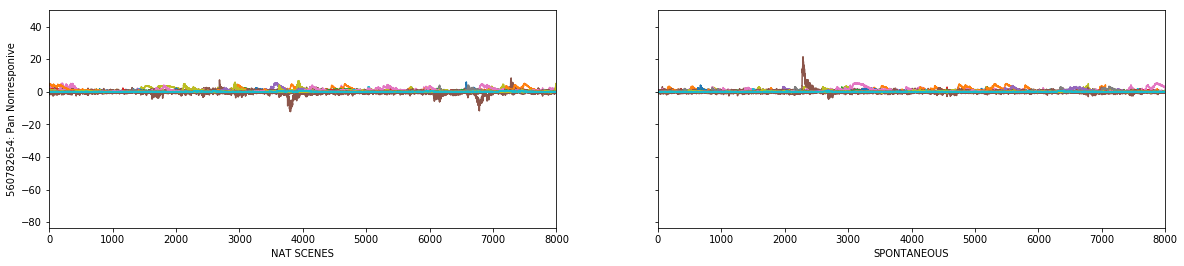

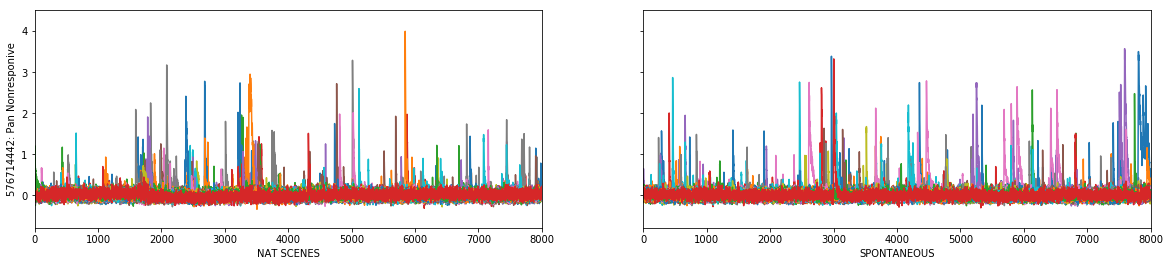

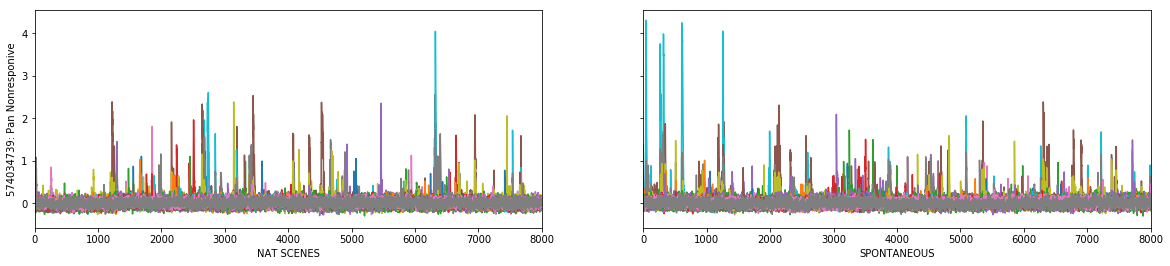

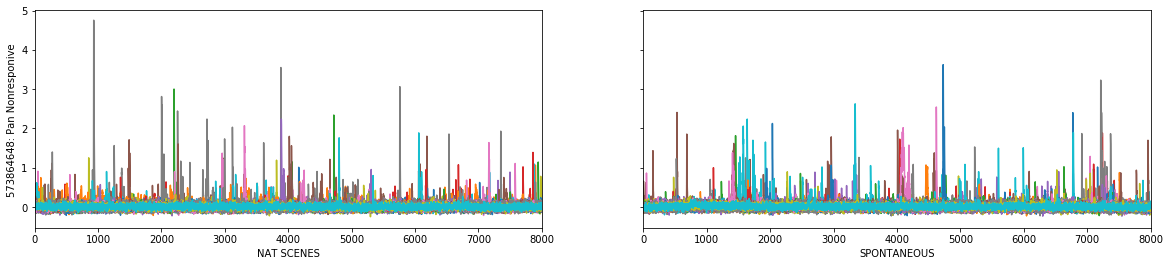

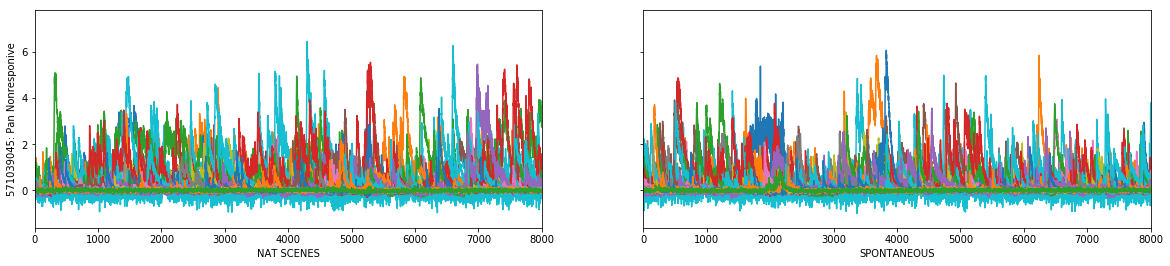

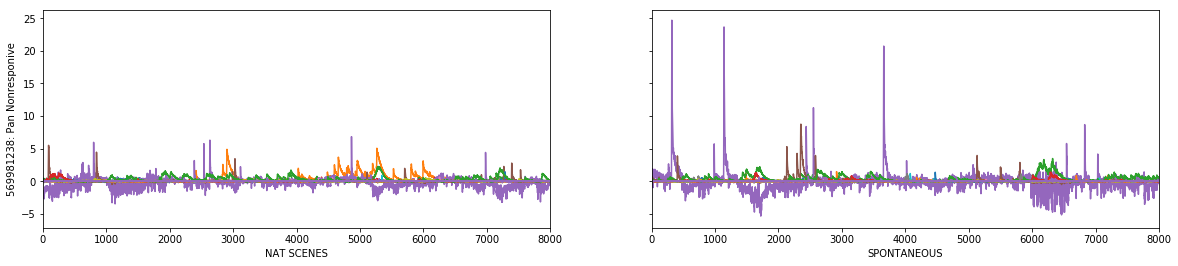

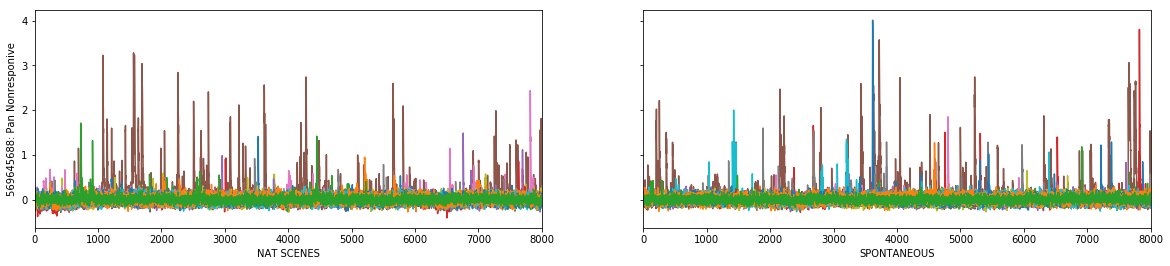

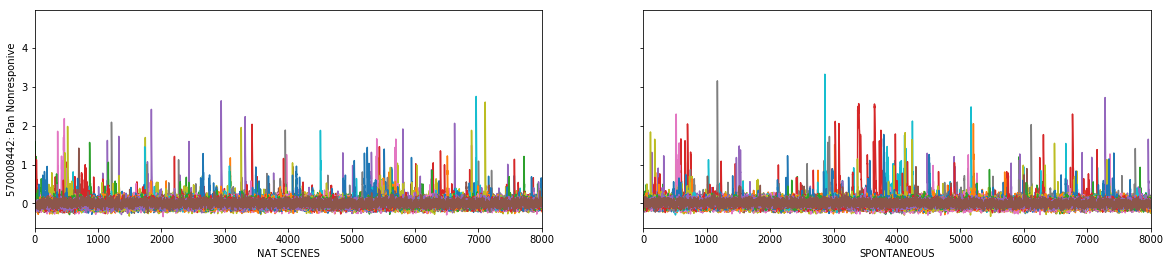

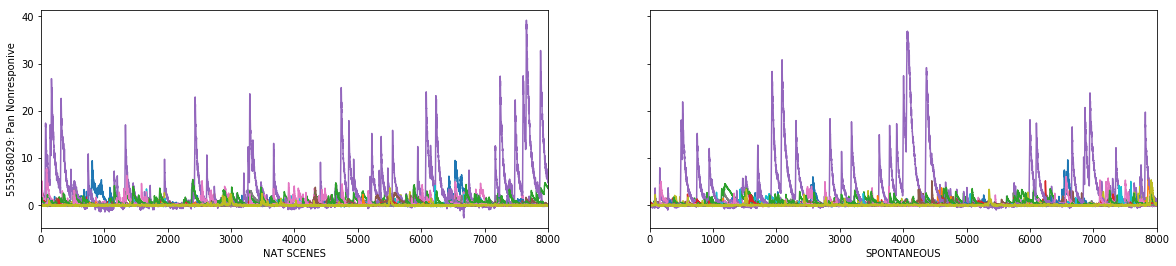

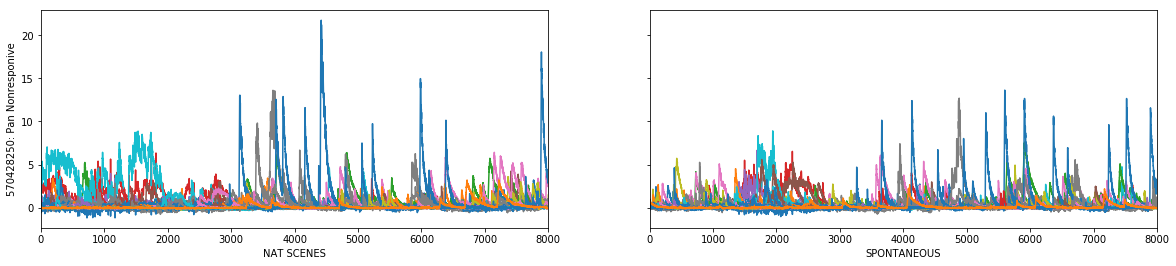

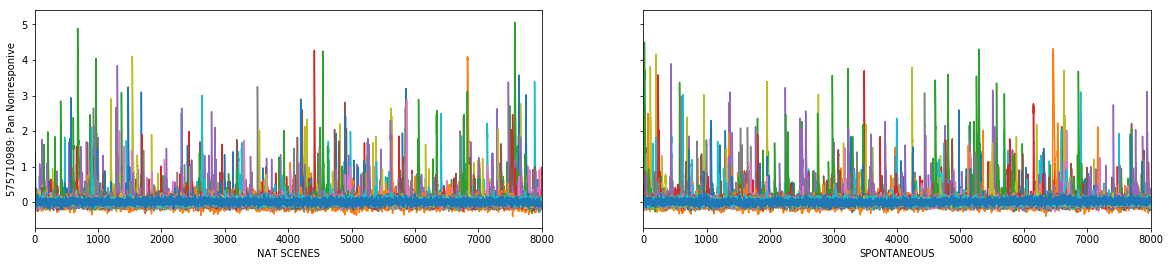

In [212]:
# Loop through each experimental container to create an image with 2 plots
    # Plot 1 [Left Plot] shows delta F trace from natural scenes (First 8000 frames so can compare to 8000 frames of spontaneous)
    # Plot 2[Right Plot] shows delta F trace from spontaneous in session_B (all 8000 frames)
for exp in exp_lis:
    fig, (ax1, ax2)= plt.subplots(1, 2, sharey='row', figsize=(20,4))
    for cell in filteredtrace[exp]['natural_scenes']['nor']:
        ax1.plot(cell)
    for cell in filteredtrace[exp]['spontaneous']['nor']:
        ax2.plot(cell)
    ax1.set( ylabel=(str(exp) + ": Pan Nonresponive"))
    ax1.set( xlabel='NAT SCENES')
    ax1.set_xlim(0,8000)
    ax2.set_xlim(0,8000)
    ax2.set( xlabel='SPONTANEOUS')
# To save images unhash following:
    #plt.savefig((str(exp) + "activity.png"))

## PCA BY IMAGE STIMULI

In [230]:
## PCA on delta f trace during natural scenes
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
import itertools
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns; sns.set()
#Use function below to print PCA during natural scenes for the cells of a given responsivity class for a given exp container id 
def generate_natscenes_pca(exp_container_id, responsivity_category, dimensionality, createpng):
    """
    INPUT:
        exp_container_id: choose experimental mouse of interest and use their experimental container id
        responsivity_category: choose category of cell responsivity type, see list below for options
            session_id_A: nor, all, dg_nor
            session_id_B: nor, all, ns_nor, sg_nor
            session_id_B: nor, all
        dimensionality: Choose the dimensions of the PCA plot between the following: '2D' or '3D'
        createpng: creates a png of the pca image generated, choose between: 'yes' and 'no'
    OUTPUT: PCA plotted in either 2 or 3 dimensions for specified input
    """
    trace=np.array(filteredtrace[exp_container_id]['natural_scenes'][responsivity_category]) #Change ['0'] to look @ diff categories, here looking at non responsive to all visual stimuli
    X=trace
    PCmat = X - X.mean(axis=1)[:, np.newaxis]
    pca = PCA(n_components = 5) #'mle', svd_solver='full')
    pca.fit(PCmat)
    pc1=pca.components_[0]
    pc2=pca.components_[1]
    pc3=pca.components_[2]
    cm=stim_dict[553568029].frame
    cma=np.array(cm)
    color_dict = {}
    cma_i = 0
    cm=stim_dict[553568029].frame
    cma=np.array(cm)
    sns.palplot(sns.hls_palette(60, l=.5, s=.2))
    sns.palplot(sns.hls_palette(60, l=.6, s=1))
    c1 = sns.hls_palette(60, l=.4, s=.3)
    c2 = sns.hls_palette(60, l=.5, s=.8)
    cols = c1[:-1] + c2
    cma_uniq = np.unique(cma)
    colors_dict = dict(itertools.izip(cma_uniq,cols))
    fig = plt.figure(figsize = (9,6))
    x_split = np.split(pc1[:41650], 5950)
    y_split = np.split(pc2[:41650], 5950)
    
    if dimensionality=='3D':
        z_split = np.split(pc3[:41650], 5950) 
        ax = fig.add_subplot(111, projection = '3d') #3D
        for idx, x_splits in enumerate(x_split):
            d3=ax.plot(x_split[idx], y_split[idx], z_split[idx], color= colors_dict[cma[idx]]) # 3D
        if createpng=='yes':
            plt.savefig((str(exp_container_id) + "_PCA_ns_" + str(responsivity_category) + "_3d.png")) #Unhash
        return d3
    if dimensionality=='2D':
        ax = fig.add_subplot(111) # 2D
        for idx, x_splits in enumerate(x_split):
            d2=ax.plot(x_split[idx], y_split[idx], color= colors_dict[cma[idx]]) #2D
        if createpng=='yes':
            plt.savefig((str(exp_container_id) + "_PCA_ns_" + str(responsivity_category) + "_2d.png")) #Unhash
        return d2
 

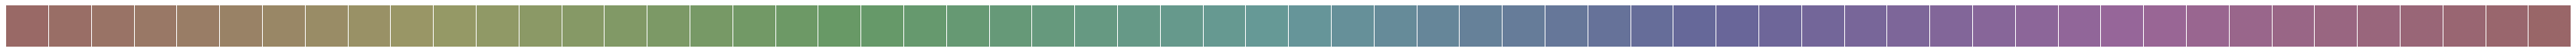

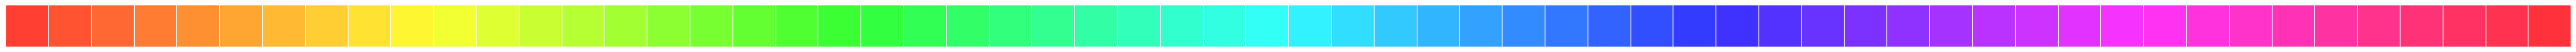

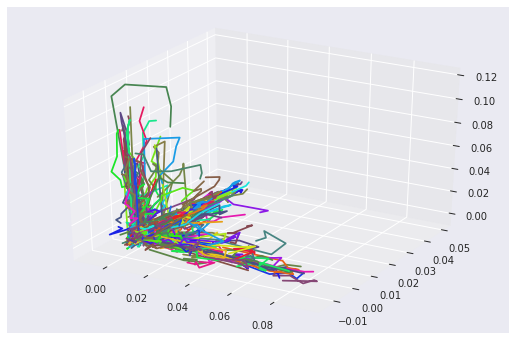

In [232]:
# Generate a PCA plot
generate_natscenes_pca(exp_lis[0], 'nor', '3D', 'no')
# This plot specifies the following
    # Mouse= exp_lis[0]
    # Reponsivity class of cells plotted= 'nor' (these are cells that do not respond to any stimuli)
    # 3D: this means the PCA will plot in 3D instead of 2D
    # no: this will not upload a properly labeled png of the plotted PCA to my AWS folder

In [ ]:
# This for loop takes a long time to run ~ 1 hr
# This will upload images to AWS, each image represents the network behavior projected onto the PCA space
    # Most of image in purple: represents network behavior for all of natural scenes
    # Subset of data in purple represents network behavior for one particular type of frame presentation for all its repititions during natural scenes
# Export images created in tar.gz and use to create GIF!
%matplotlib inline
from sklearn.decomposition import PCA
#Reset colors dictionary
# for x in colors_dict:
#     colors_dict[x]= (0.52, 0.28, 0.48160000000000003)
def pca(trace):
    fig = plt.figure(figsize = (9,6))
    ax = fig.add_subplot(111, projection = '3d')
    for i in range(0, len(colors_dict)):
         #Reset colors dictionary
        for x in colors_dict:
            colors_dict[x]= (0.52, 0.28, 0.48160000000000003)
        colors_dict[i]=(0.9, 0.09999999999999998, 0.13200000000000017)
        X=trace
        PCmat = X - X.mean(axis=1)[:, np.newaxis]
        pca = PCA(n_components = 5) #'mle', svd_solver='full')
        pca.fit(PCmat)
        pc1=pca.components_[0]
        pc2=pca.components_[1]
        pc3=pca.components_[2]
        x_split = np.split(pc1[:41650], 5950)
        y_split = np.split(pc2[:41650], 5950)
        z_split = np.split(pc3[:41650], 5950)
        for idx, x_splits in enumerate(x_split):
            if idx==i:
                ax.plot(x_split[idx], y_split[idx], z_split[idx], color= colors_dict[i],alpha=1)
            else:
                ax.plot(x_split[idx], y_split[idx], z_split[idx], color= colors_dict[cma[idx]], alpha=.85)
        plt.savefig((str(exp_lis[7]) +'_' + str(i) + "_PCA_epoch_nor.jpeg"))
        ax.cla()
pca(np.array(filteredtrace[exp_lis[7]]['natrual_scenes']['nor']))